Uploading Kaggle API Key

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (3).json


{'kaggle (3).json': b'{"username":"urja2007","key":"0b43659003cd96e7f480e7504df8a523"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Download Dataset

In [3]:
!kaggle datasets download -d apollo2506/eurosat-dataset

Dataset URL: https://www.kaggle.com/datasets/apollo2506/eurosat-dataset
License(s): CC0-1.0
eurosat-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


Unzipping the Dataset


In [4]:
!unzip eurosat-dataset.zip -d eurosat_data

Archive:  eurosat-dataset.zip
replace eurosat_data/EuroSAT/AnnualCrop/AnnualCrop_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Import Libraries

In [5]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import random
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import time

In [6]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print("Found GPU")
else:
    torch.device("cpu")

print("Pytorch version:", torch.__version__)

Found GPU
Pytorch version: 2.8.0+cu126


Data Structure

In [7]:
# Check top-level directories
print(os.listdir("eurosat_data")) #lists all subfolders inside eurosat_data.(10)

['EuroSATallBands', 'EuroSAT']


In [8]:
os.listdir("eurosat_data/EuroSAT")

['HerbaceousVegetation',
 'Residential',
 'SeaLake',
 'label_map.json',
 'PermanentCrop',
 'train.csv',
 'Pasture',
 'Industrial',
 'test.csv',
 'Forest',
 'validation.csv',
 'AnnualCrop',
 'River',
 'Highway']

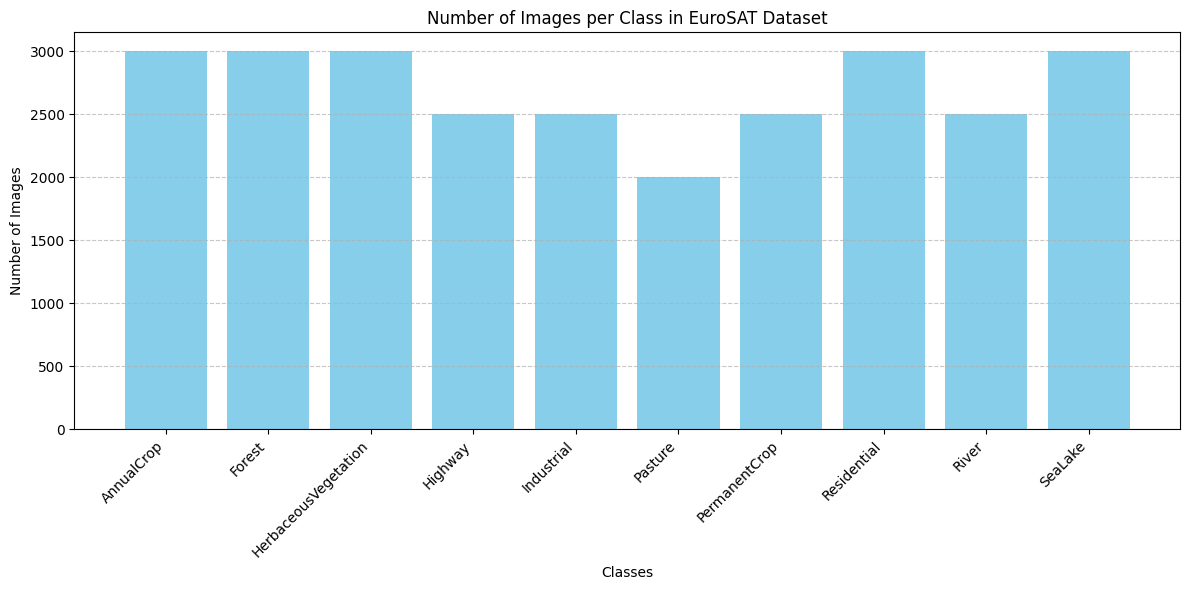

In [9]:
# Path to your dataset
data_path = "eurosat_data/EuroSAT"

classes = []
num_images = []

# Collect class names and number of images
for folder in sorted(os.listdir(data_path)):
    class_path = os.path.join(data_path, folder)
    if os.path.isdir(class_path):
        classes.append(folder)
        num_images.append(len(os.listdir(class_path)))

# Plot bar graph
plt.figure(figsize=(12,6))
plt.bar(classes, num_images, color='skyblue')
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Number of Images per Class in EuroSAT Dataset")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Display Images

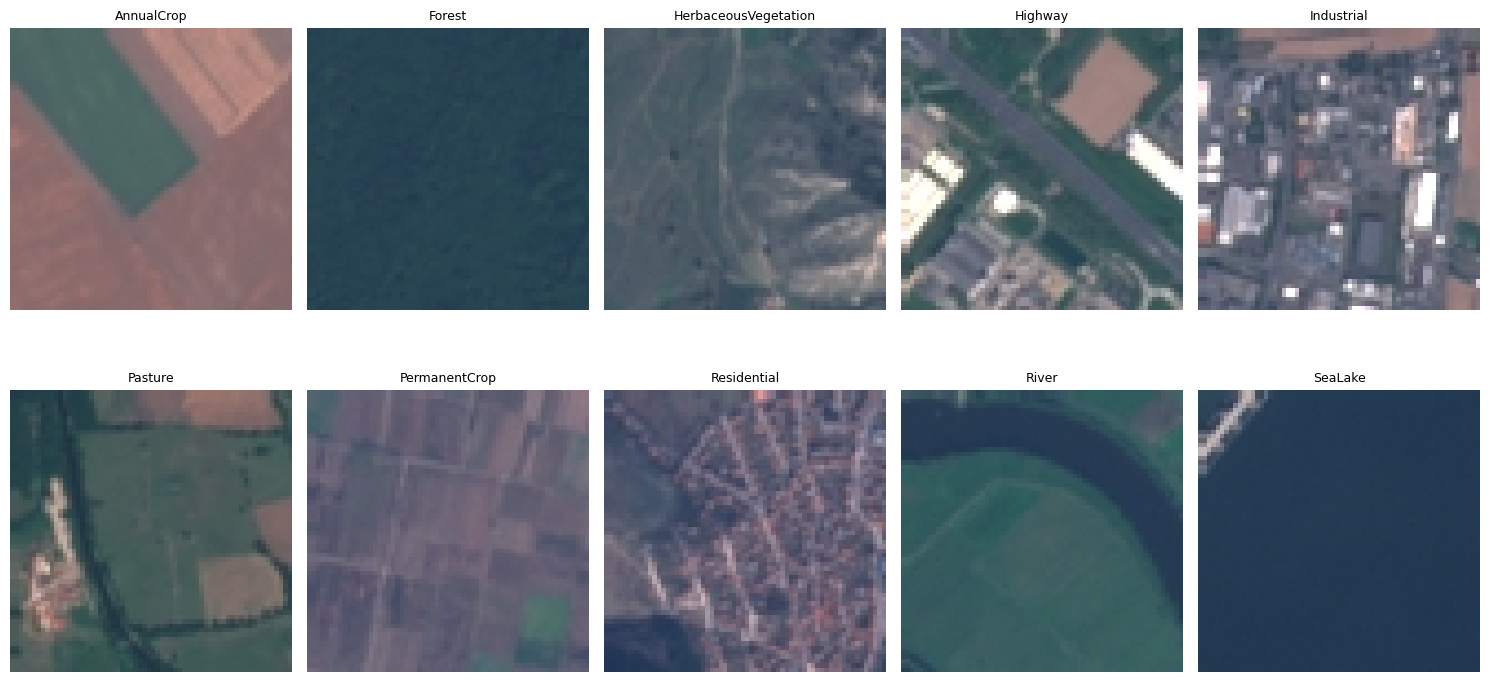

In [10]:
folders = sorted(os.listdir(data_path))

plt.figure(figsize=(15, 8))

for i, folder in enumerate(folders):
    class_path = os.path.join(data_path, folder)
    if os.path.isdir(class_path):
        # Pick first image (or random)
        sample_img = os.listdir(class_path)[0]  # you can use random.choice() for randomness
        img_path = os.path.join(class_path, sample_img)

        img = Image.open(img_path)

        # Plot
        plt.subplot(2, 5, i+1)  # 2 rows × 5 columns for 10 classes
        plt.imshow(img)
        plt.title(folder, fontsize=9)
        plt.axis("off")

plt.tight_layout()
plt.show()

Data Transformation and Splitting

In [11]:
df_test = pd.read_csv('/content/eurosat_data/EuroSAT/test.csv')
df_train = pd.read_csv('/content/eurosat_data/EuroSAT/train.csv')
df_val = pd.read_csv('/content/eurosat_data/EuroSAT/validation.csv')


In [12]:
class EurosatDataset(Dataset):
    def __init__(self, csv_file, data_path, transform=None):
        self.data = pd.read_csv(csv_file)
        self.folder_base = data_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.folder_base, row['Filename'])
        label = torch.tensor(row['Label'], dtype=torch.long)

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

In [13]:
# Transforms (resize + normalize for EfficientNet)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # Imagenet mean
                         [0.229, 0.224, 0.225]) # Imagenet std
])

# Datasets
train_dataset = EurosatDataset(csv_file=os.path.join(data_path, "train.csv"),
                               data_path=data_path, transform=transform)

val_dataset = EurosatDataset(csv_file=os.path.join(data_path, "validation.csv"),
                             data_path=data_path, transform=transform)

test_dataset = EurosatDataset(csv_file=os.path.join(data_path, "test.csv"),
                              data_path=data_path, transform=transform)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Class Distribution in Train, Validation, and Test Sets

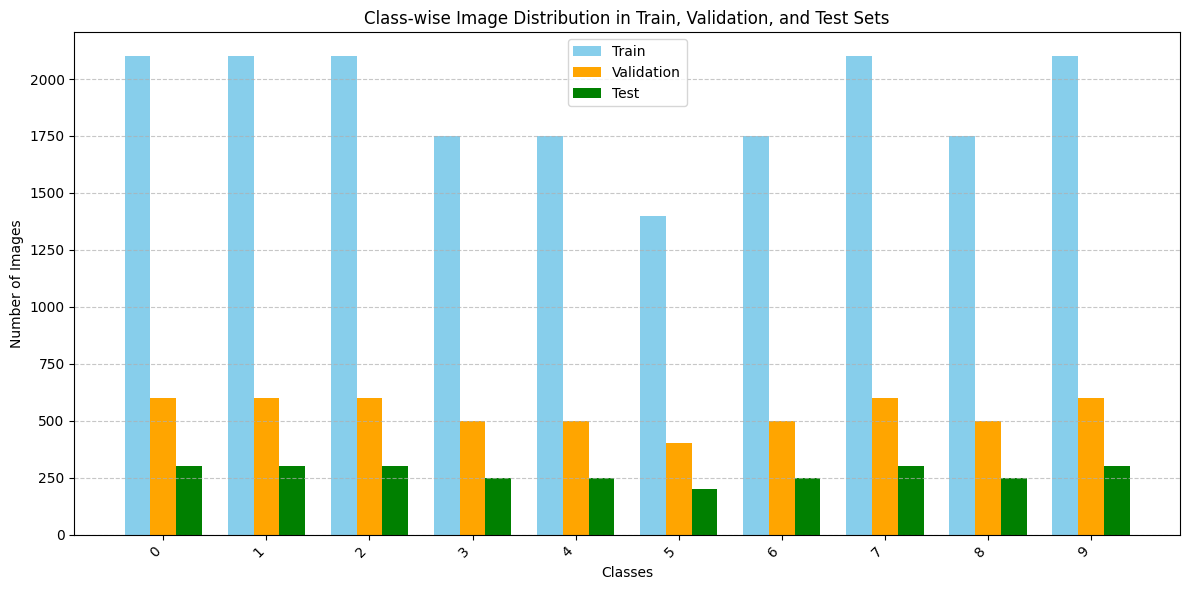

In [14]:
# Function to count images per class from CSV
def count_images_per_class(csv_file):
    df = pd.read_csv(csv_file)
    class_counts = df['Label'].value_counts().sort_index()
    return class_counts

# Count images per class for each split
train_counts = count_images_per_class(os.path.join(data_path, "train.csv"))
val_counts   = count_images_per_class(os.path.join(data_path, "validation.csv"))
test_counts  = count_images_per_class(os.path.join(data_path, "test.csv"))

classes = train_counts.index.tolist()  # assuming same class names in all splits

# Plot grouped bar chart
x = range(len(classes))
width = 0.25

plt.figure(figsize=(12,6))
plt.bar([i - width for i in x], train_counts.values, width=width, label='Train', color='skyblue')
plt.bar(x, val_counts.values, width=width, label='Validation', color='orange')
plt.bar([i + width for i in x], test_counts.values, width=width, label='Test', color='green')

plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Class-wise Image Distribution in Train, Validation, and Test Sets")
plt.xticks(x, classes, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Model

In [15]:
# Load pretrained EfficientNet
model = models.efficientnet_b0(pretrained=True)

# Replace classifier for 10 classes
num_classes = 10
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(DEVICE)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Training

In [17]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=15):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        train_loss = running_loss/len(train_loader)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = 100 * val_correct / val_total
        val_loss /= len(val_loader)

        # Store for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% "
              f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%")

    return train_losses, val_losses, train_accs, val_accs


In [18]:
# Train the model and get the history
train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs=15
)

Epoch [1/15] Train Loss: 0.4362 Train Acc: 88.99% Val Loss: 0.0795 Val Acc: 97.46%
Epoch [2/15] Train Loss: 0.0920 Train Acc: 97.07% Val Loss: 0.0635 Val Acc: 97.93%
Epoch [3/15] Train Loss: 0.0619 Train Acc: 97.95% Val Loss: 0.0557 Val Acc: 98.11%
Epoch [4/15] Train Loss: 0.0448 Train Acc: 98.63% Val Loss: 0.0551 Val Acc: 98.11%
Epoch [5/15] Train Loss: 0.0289 Train Acc: 99.10% Val Loss: 0.0544 Val Acc: 98.24%
Epoch [6/15] Train Loss: 0.0230 Train Acc: 99.33% Val Loss: 0.0494 Val Acc: 98.33%
Epoch [7/15] Train Loss: 0.0235 Train Acc: 99.33% Val Loss: 0.0529 Val Acc: 98.50%
Epoch [8/15] Train Loss: 0.0181 Train Acc: 99.44% Val Loss: 0.0588 Val Acc: 98.17%
Epoch [9/15] Train Loss: 0.0129 Train Acc: 99.57% Val Loss: 0.0491 Val Acc: 98.50%
Epoch [10/15] Train Loss: 0.0167 Train Acc: 99.48% Val Loss: 0.0520 Val Acc: 98.50%
Epoch [11/15] Train Loss: 0.0094 Train Acc: 99.72% Val Loss: 0.0526 Val Acc: 98.43%
Epoch [12/15] Train Loss: 0.0124 Train Acc: 99.62% Val Loss: 0.0706 Val Acc: 98.20%
E

Save Model

In [19]:
# Save entire model (architecture + weights)
torch.save(model, "efficientnet_model.pth")

# OR: Save only weights (recommended if you plan to reload into same architecture)
torch.save(model.state_dict(), "efficientnet_weights.pth")

In [20]:
from google.colab import files

# Download both versions (choose whichever you saved)
files.download("efficientnet_model.pth")       # full model
files.download("efficientnet_weights.pth")     # only weights

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
# DEVICE = torch.device("cpu")
DEVICE = torch.device("cuda:0") #change to cpu if you don't have a GPU

In [22]:
model = models.efficientnet_b0(pretrained=False, num_classes=10)
model.load_state_dict(torch.load("efficientnet_weights.pth", map_location=DEVICE))
model.eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Model Evaluation

In [23]:
def test_model(model, test_loader, device=DEVICE):
    model.eval()
    model.to(device)  # Move model to the specified device
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"Test Accuracy: {100*correct/total:.2f}%")

In [24]:
def evaluate_model_with_report(model, test_loader, class_names):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)   # <-- moved both
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())  # back to CPU for sklearn
            y_pred.extend(preds.cpu().numpy())

    report = classification_report(y_true, y_pred, target_names=class_names, digits=3)
    print(report)
    return report

In [25]:
def plot_confusion_matrix(model, data_loader, class_names, device=DEVICE):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    plt.figure(figsize=(8,6))
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

In [26]:

def plot_roc_curve(model, data_loader, class_names, device=DEVICE):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)  # convert logits -> probabilities

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Binarize labels for multi-class ROC
    y_true = label_binarize(all_labels, classes=list(range(len(class_names))))
    n_classes = y_true.shape[1]

    plt.figure(figsize=(8, 6))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    # Random baseline
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (One-vs-Rest)")
    plt.legend(loc="lower right")
    plt.show()


In [27]:
def plot_precision_recall_curve(model, data_loader, class_names, device=DEVICE):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)

            # raw softmax scores
            probs = torch.softmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # Binarize labels for multi-class
    y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))

    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_scores[:, i])
        ap = average_precision_score(y_true_bin[:, i], y_scores[:, i])

        plt.plot(recall, precision, lw=2, label=f"{class_name} (AP={ap:.2f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curve")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [28]:
def show_sample_predictions(model, dataset, class_names, device=DEVICE, num_samples=10):
    model.eval()
    plt.figure(figsize=(15, 8))

    # pick random indices
    indices = random.sample(range(len(dataset)), num_samples)

    with torch.no_grad():
        for i, idx in enumerate(indices):
            img, label = dataset[idx]
            img_input = img.unsqueeze(0).to(device)  # add batch dim
            output = model(img_input)
            _, pred = torch.max(output, 1)

            true_class = class_names[label]
            pred_class = class_names[pred.item()]

            # Plot
            plt.subplot(2, 5, i+1)
            plt.imshow(img.permute(1, 2, 0).cpu().numpy())  # CHW → HWC
            plt.title(f"True: {true_class}\nPred: {pred_class}", fontsize=10)
            plt.axis("off")

    plt.suptitle("Sample Predictions", fontsize=16)
    plt.tight_layout()
    plt.show()

In [29]:
def measure_inference_time(model, data_loader, device=DEVICE, num_batches=10):
    model.eval()
    times = []
    n_images = 0

    with torch.no_grad():
        for b, (imgs, _) in enumerate(data_loader):
            if b >= num_batches:  # limit batches for speed
                break
            imgs = imgs.to(device)

            # Warm-up (especially important on GPU to avoid first-call overhead)
            _ = model(imgs)

            start = time.time()
            outputs = model(imgs)
            end = time.time()

            batch_time = (end - start)
            times.append(batch_time)
            n_images += imgs.size(0)

    avg_time_per_image = sum(times) / n_images
    print(f"Average Inference Time per Image: {avg_time_per_image*1000:.4f} ms")
    return avg_time_per_image

In [30]:
test_model(model, test_loader)

Test Accuracy: 99.00%


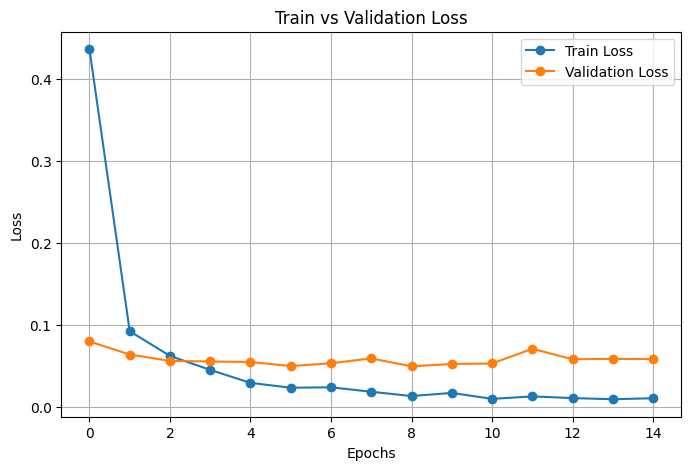

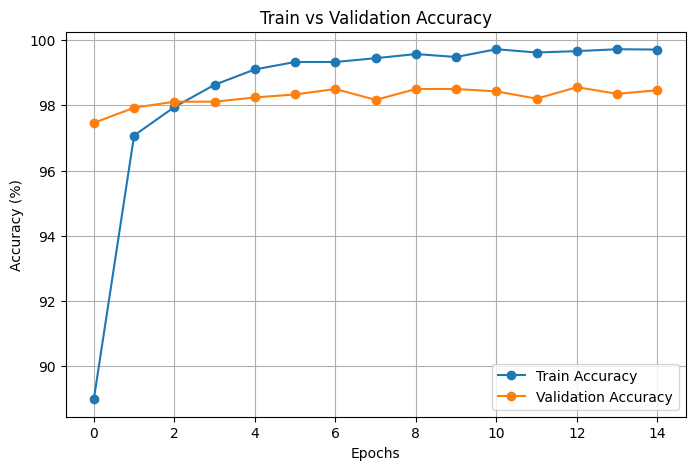

In [31]:
# ---- Plot Train vs Validation Loss ----
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ---- Plot Train vs Validation Accuracy ----
plt.figure(figsize=(8,5))
plt.plot(train_accs, label="Train Accuracy", marker='o')
plt.plot(val_accs, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


Classification Report

In [32]:
# Example usage
class_names = [
    'AnnualCrop', 'Forest', 'HerbaceousVegetation',
    'Highway', 'Industrial', 'Pasture',
    'PermanentCrop', 'Residential', 'River', 'SeaLake'
]

report = evaluate_model_with_report(model, test_loader, class_names)

                      precision    recall  f1-score   support

          AnnualCrop      0.980     1.000     0.990       300
              Forest      0.997     0.993     0.995       300
HerbaceousVegetation      0.983     0.990     0.987       300
             Highway      0.984     0.988     0.986       250
          Industrial      0.992     0.996     0.994       250
             Pasture      0.990     0.970     0.980       200
       PermanentCrop      0.992     0.976     0.984       250
         Residential      1.000     0.997     0.998       300
               River      0.984     0.984     0.984       250
             SeaLake      0.997     0.997     0.997       300

            accuracy                          0.990      2700
           macro avg      0.990     0.989     0.989      2700
        weighted avg      0.990     0.990     0.990      2700



Confusion Matrix

<Figure size 800x600 with 0 Axes>

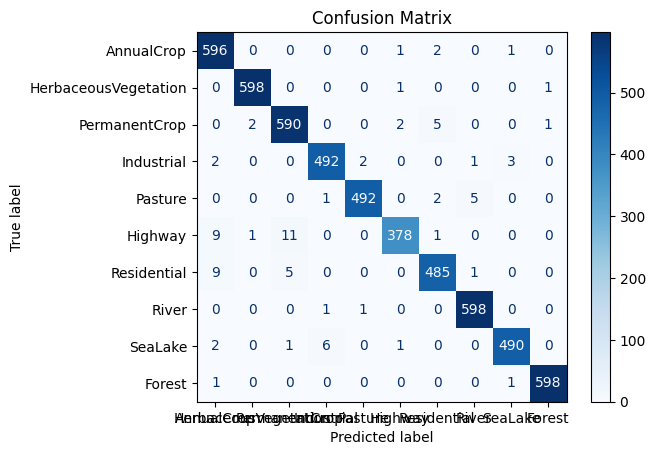

In [33]:
class_names = df_train['ClassName'].unique().tolist()

plot_confusion_matrix(model, val_loader, class_names)

ROC Curve

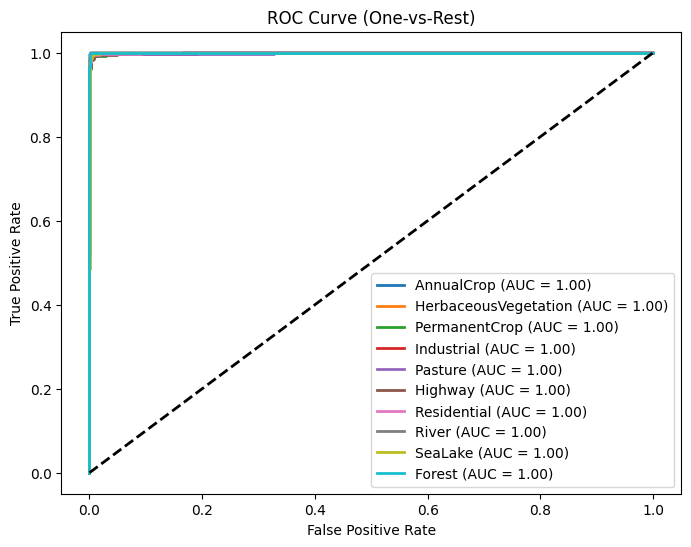

In [34]:
plot_roc_curve(model, val_loader, class_names)

Precision Recoll Curve

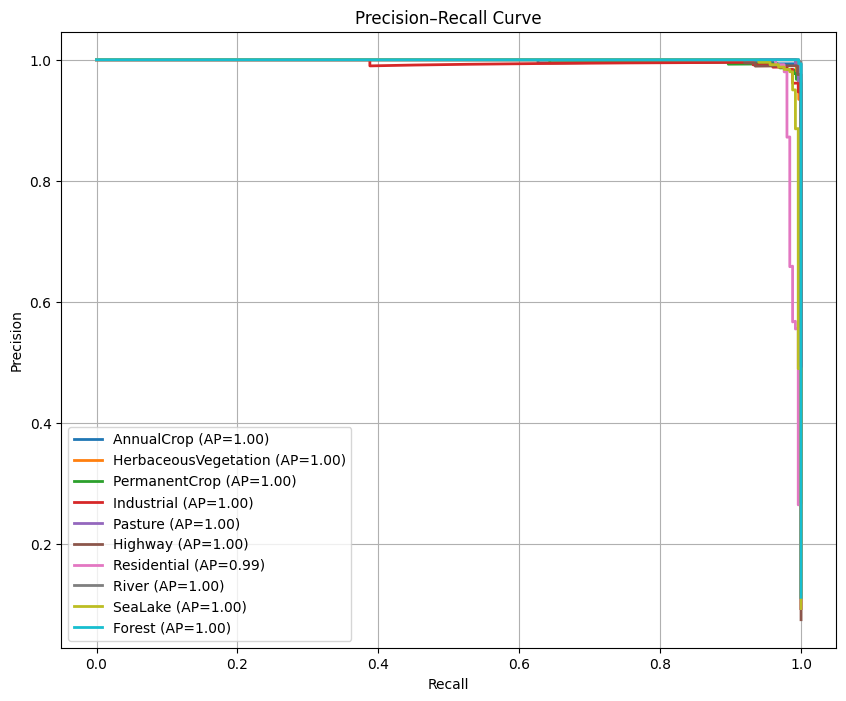

In [35]:
plot_precision_recall_curve(model, test_loader, class_names)

Sample Predictions

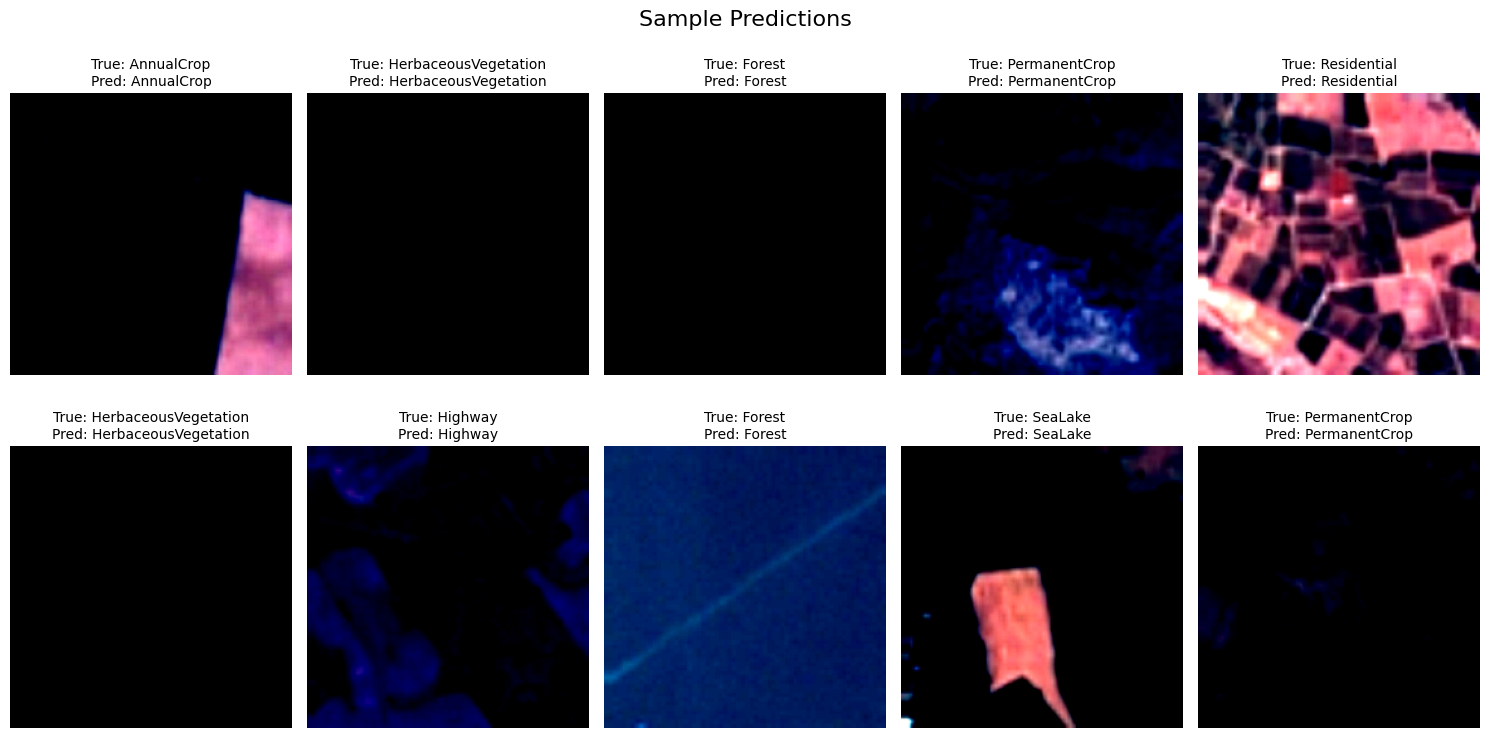

In [36]:
show_sample_predictions(model, val_loader.dataset, class_names)

Imference Time per image

In [37]:
avg_time = measure_inference_time(model, test_loader, device=DEVICE, num_batches=20)

Average Inference Time per Image: 0.5040 ms
